# MEG data loading and pre-processing 

### Packages import

Packages are Python librairies, i.e. files that contain pre-written functions. We need to import the packages before using the functions that they include. For our purpose (MEG/EEG data analysis), most of the functions will be included in the MNE package, but we may have to use other packages too.

In [1]:
! pip install mne 
# I know we said this is bad practice, but let's do it anyways so we don't have to open any terminal ;)
! pip install scikit-learn --user

import mne # Here we import mne, the package that will contain most of the function that we will use today.
from mne.datasets.brainstorm import bst_raw # It is possible to import functions individually. This is helpful since it 
                                            # saves time, memory, and makes the calls to the function easier.
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
%matplotlib notebook
# ^ This last line lets us use the interactive plots in Jupyter

### Loading the data

In [2]:
data_path = bst_raw.data_path() # The function bst_raw downloads the Brainstorm tutorial dataset 
                                # and stores the folder's path in "data_path".
                                # It is possible to specify a destination in the parenthesis : data_path('/home/yann/mne-tuto')
                                # (don't forget to double the backslashes in windows)

In [3]:
raw_fname = data_path + '/MEG/bst_raw/subj001_somatosensory_20111109_01_AUX-f.ds' # Now, we will access the file 
                                                                          # containing the MEG data in .fif format
# If you want to use your own data instead of the tutorial data, put the full path to your datafile in raw_fname

raw = mne.io.read_raw_ctf(raw_fname, preload=True) # Let's load the datafile and store it in "raw", an MNE data object.
                                                   # If your data is not in .fif, there are other MNE
                                                   # functions that can open .cnt, .edf, .gdf and so on...
# Here is a list of the supported formats (with corresponding functions) : https://www.martinos.org/mne/stable/manual/io.html#creating-mne-data-structures-from-arbitrary-data-from-memory

ds directory : /home/hyruuk/mne_data/MNE-brainstorm-data/bst_raw/MEG/bst_raw/subj001_somatosensory_20111109_01_AUX-f.ds
    res4 data read.
    hc data read.
    Separate EEG position data file not present.
    Quaternion matching (desired vs. transformed):
       0.84   69.49    0.00 mm <->    0.84   69.49    0.00 mm (orig :  -44.30   51.45 -252.43 mm) diff =    0.000 mm
      -0.84  -69.49    0.00 mm <->   -0.84  -69.49   -0.00 mm (orig :   46.28  -53.58 -243.47 mm) diff =    0.000 mm
      86.41    0.00    0.00 mm <->   86.41    0.00   -0.00 mm (orig :   63.60   55.82 -230.26 mm) diff =    0.000 mm
    Coordinate transformations established.
    Reading digitizer points from ['/home/hyruuk/mne_data/MNE-brainstorm-data/bst_raw/MEG/bst_raw/subj001_somatosensory_20111109_01_AUX-f.ds/subj00111092011.pos']...
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
Picked positions of 2 EEG channels from channel info
    2 EEG locations added to Polhe

While the tutorial dataset is downloading, let's have a look at what is this data, and what we will do with it.
The data comes from Brainstorm's MEG median nerve tutorial (CTF) : https://neuroimage.usc.edu/brainstorm/Tutorials/MedianNerveCtf



Experiment : 
- One subject, one acquisition run of 6 minutes
- The run contains 200 electric stimulations randomly distributed between left and right:
    - 102 stimulations of the left hand
    - 98 stimulations of the right hand
- Inter-stimulus interval: jittered between [1500, 2000]ms


Data : 
- Acquisition at 1200Hz, with a CTF 275 system, subject in seating position
- Recorded at the Montreal Neurological Institute in November 2011
- Anti-aliasing low-pass filter at 300Hz, files saved with the 3rd order gradient
- Recorded channels (302):
    - 1 Stim channel indicating the presentation times of the stimuli: UPPT001 (#1)
    - 26 MEG reference sensors (#3-#28)
    - 272 MEG axial gradiometers (#29-#300)
    - 1 ECG bipolar (#301)
    - 1 vertical EOG bipolar (#302)
    - 1 Unused channels (#2)


In this tutorial, we will see the basic steps of MEG pre-processing : frequency filtering and artifact removal using ICA.
In the next notebook, we will use MNE functions to analyse our data. First we will compare the topography and power of oscillations between left and right-hand stimulation. Then we will compare the time-course of the evoked response (ERF) of both stimulation. 

### MNE data objects

The MNE data objects contains the data + some information (sampling frequency, number of channels etc...). It is very convenient since most MNE functions will be applied directly on this object, and you can access everything in the same place. 

In [4]:
raw.info.get('sfreq') # Or you can access each field separately by using get() (here, we ask for the sampling frequency)

1200.0

In [5]:
raw.info

<Info | 22 non-empty fields
    bads : list | 0 items
    ch_names : list | UPPT001, SCLK01-177, BG1-4408, BG2-4408, BG3-4408, ...
    chs : list | 302 items (STIM: 1, MISC: 1, REF_MEG: 26, MAG: 272, EEG: 2)
    comps : list | 5 items
    ctf_head_t : Transform | 3 items
    custom_ref_applied : bool | False
    dev_ctf_t : Transform | 3 items
    dev_head_t : Transform | 3 items
    dig : list | 119 items (3 Cardinal, 2 EEG, 114 Extra)
    events : list | 0 items
    experimenter : str | 7 items
    highpass : float | 0.0 Hz
    hpi_meas : list | 0 items
    hpi_results : list | 1 items
    lowpass : float | 600.0 Hz
    meas_date : NoneType | unspecified
    meas_id : dict | 4 items
    nchan : int | 302
    proc_history : list | 0 items
    projs : list | 0 items
    sfreq : float | 1200.0 Hz
    subject_info : dict | 1 items
    acq_pars : NoneType
    acq_stim : NoneType
    description : NoneType
    file_id : NoneType
    gantry_angle : NoneType
    hpi_subsystem : NoneType
    

<IPython.core.display.Javascript object>


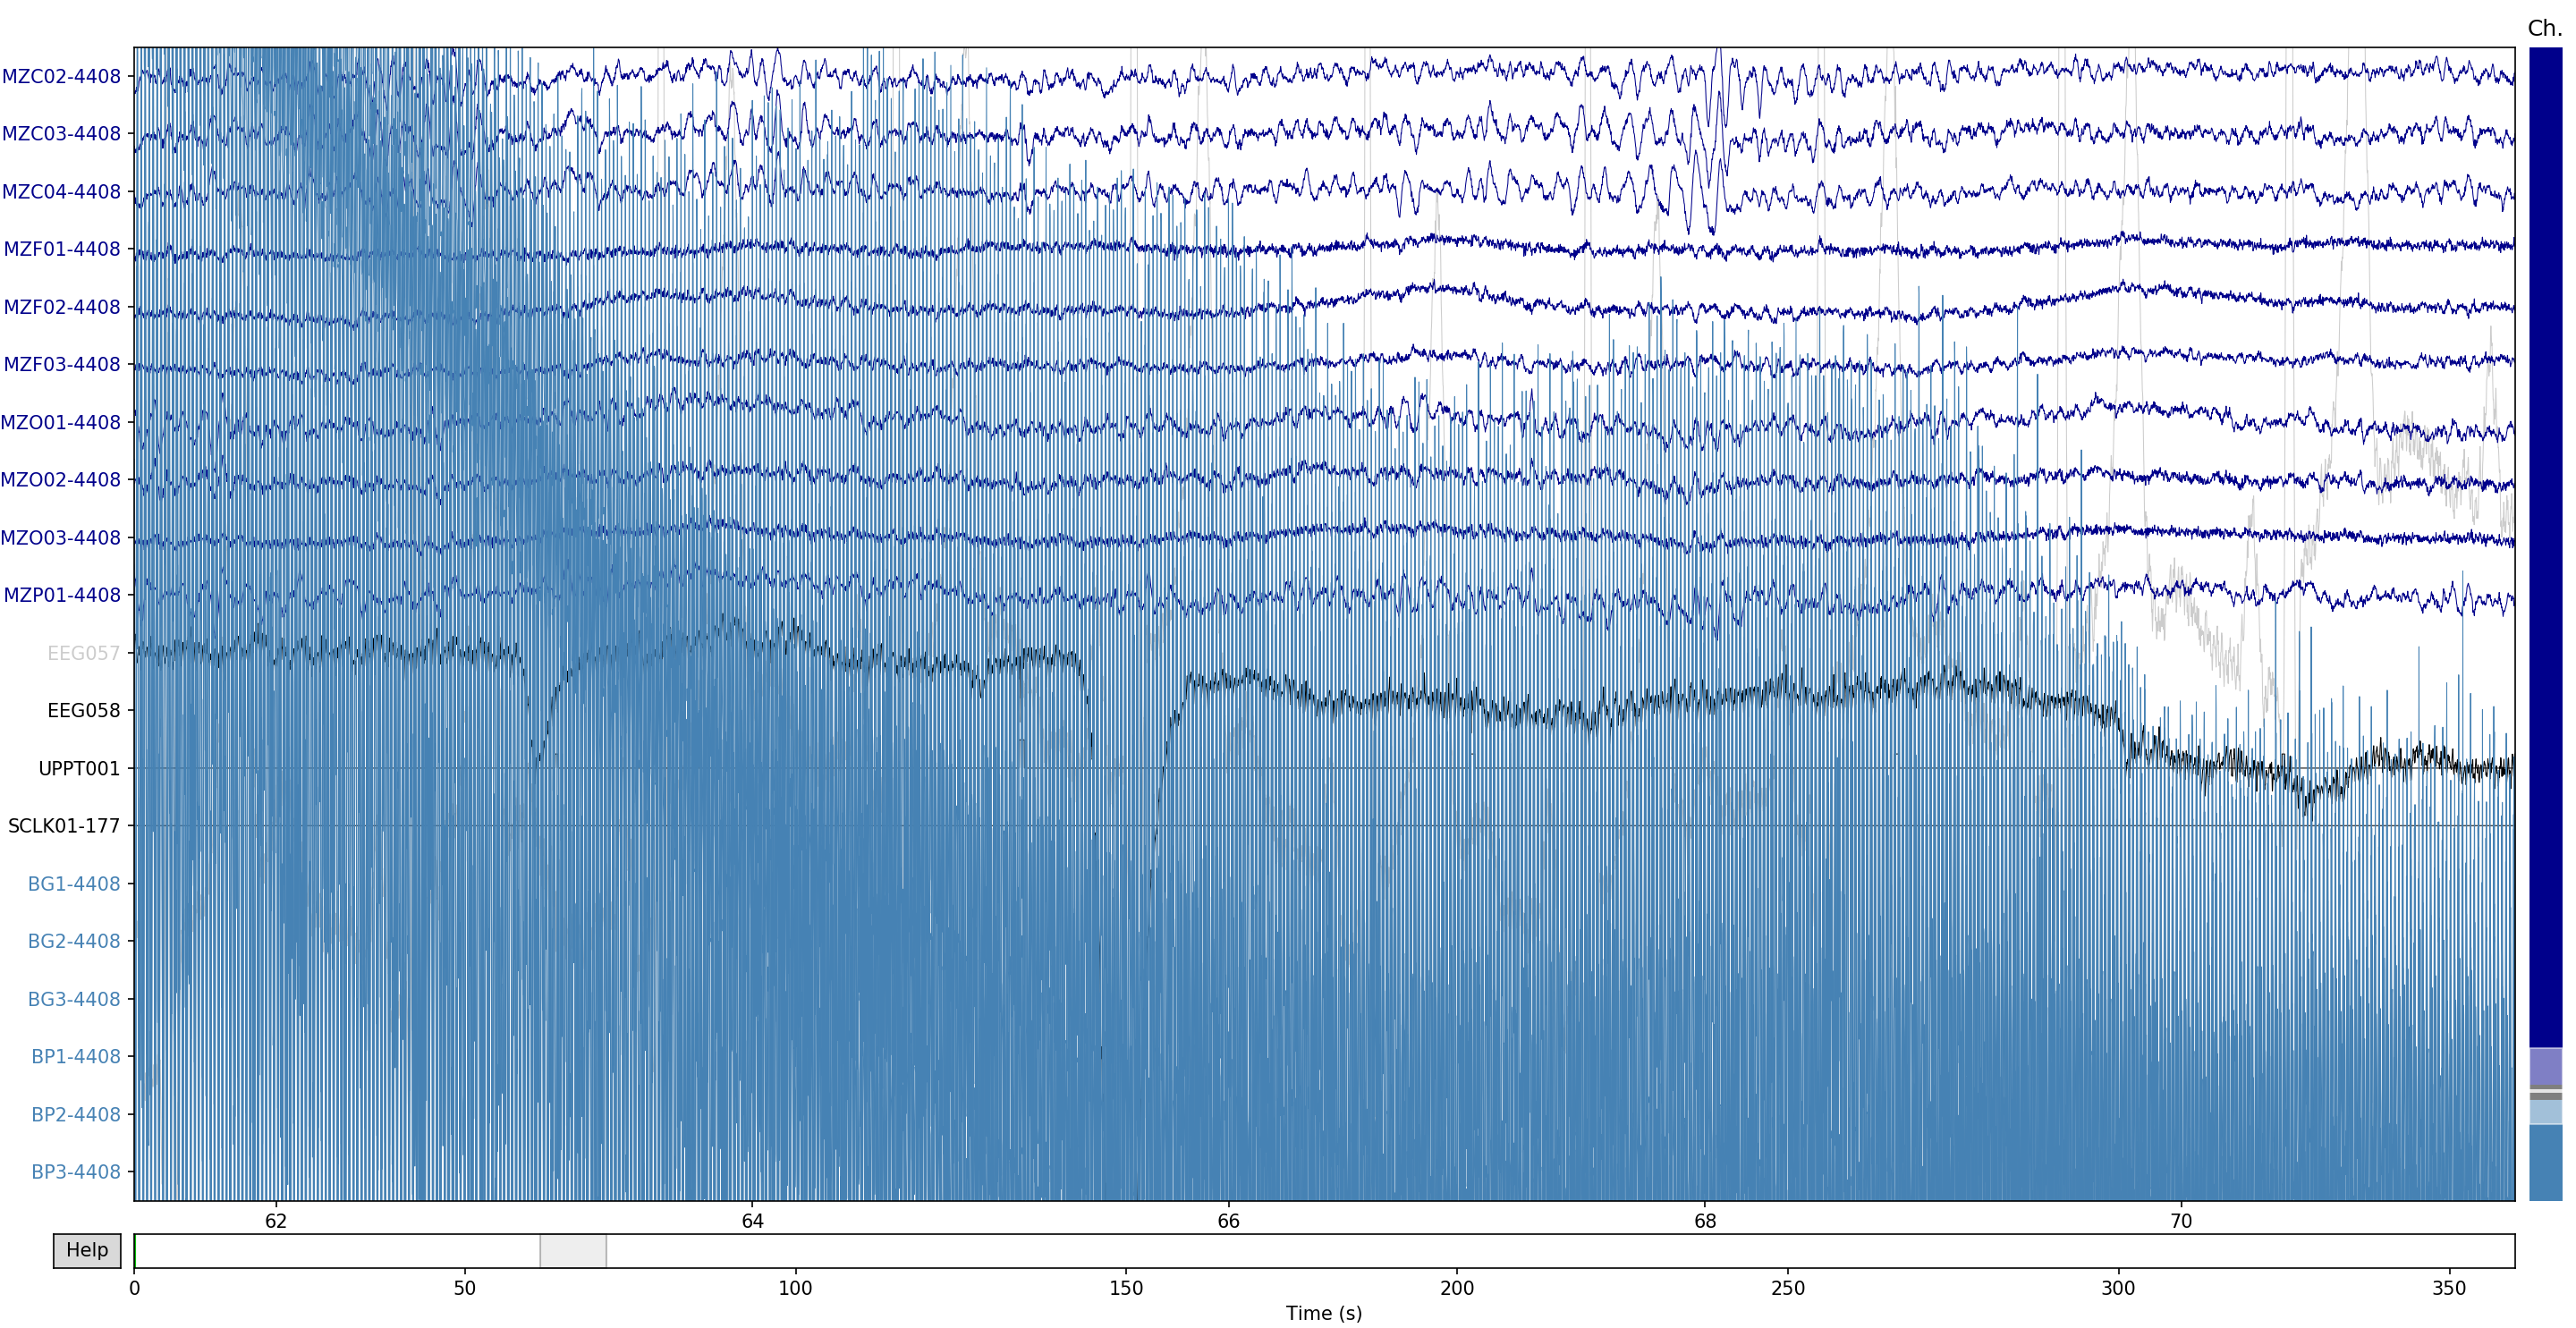

In [6]:
raw.plot(); # You can also plot the timeseries of your data and scroll to explore them visually.
           # The plot method can take many arguments to help you plot the data the way you want.
           # Any transformation commanded by these arguments (e.g. filtering) will ONLY apply to the plotted data, 
           # the content of "raw" will be left untouched.

<IPython.core.display.Javascript object>


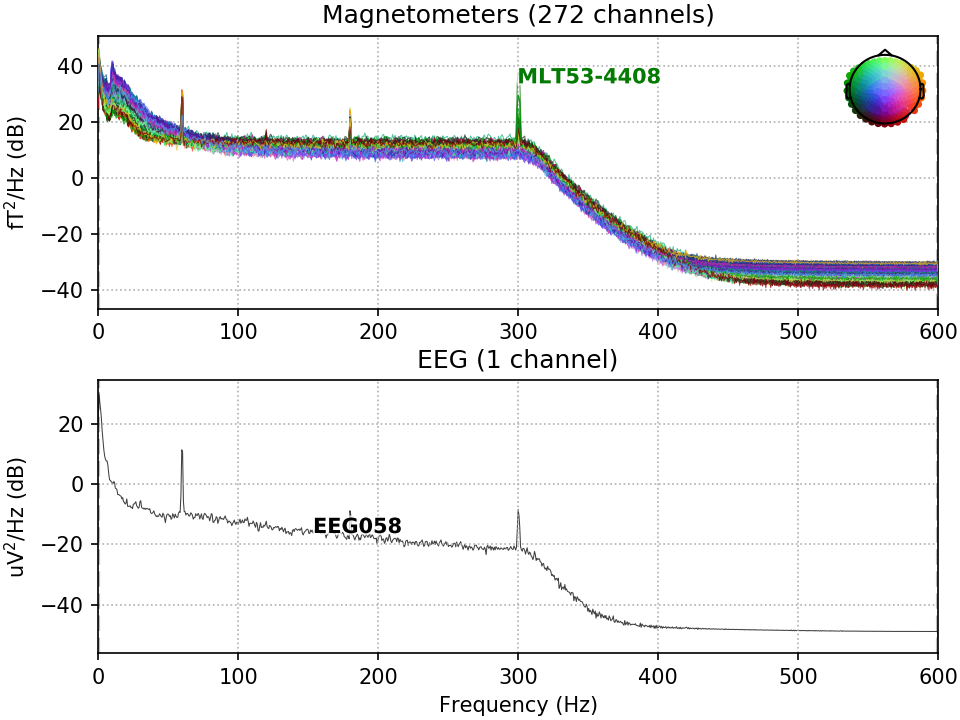

Effective window size : 1.707 (s)
Effective window size : 1.707 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


In [7]:
# Let's have a quick look at the spectrum of our data
raw.plot_psd(tmax=60., average=False);

### Filtering

Before doing anything with our data, we usually want to filter them in order to remove specific frequency bands.
1. We want to remove frequencies that are either too low or too high to be meaningful to us
    -> Band-pass filter
2. We want to remove the line noise (i.e. noise generated by the alternative current used to power electric devices)
    -> Notch filter

In [8]:
raw = raw.copy().filter(0.5, 150., fir_design="firwin") # This method applies a bandpass filter to the data in "raw".
                                           # Here, we keep only frequencies between 0.5 and 150Hz, the rest will be attenuated.
    
raw = raw.copy().notch_filter([60, 120], filter_length='auto',phase='zero', fir_design="firwin") # The notch filter will only
                                            # remove certain frequencies. Since in North America the power lines oscillates
                                            # at 60Hz, we will remove this frequency and it's first harmonic, 120Hz.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.5e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 150.00 Hz
- Upper transition bandwidth: 37.50 Hz (-6 dB cutoff frequency: 168.75 Hz)
- Filter length: 7921 samples (6.601 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 7921 samples (6.601 sec)



<IPython.core.display.Javascript object>


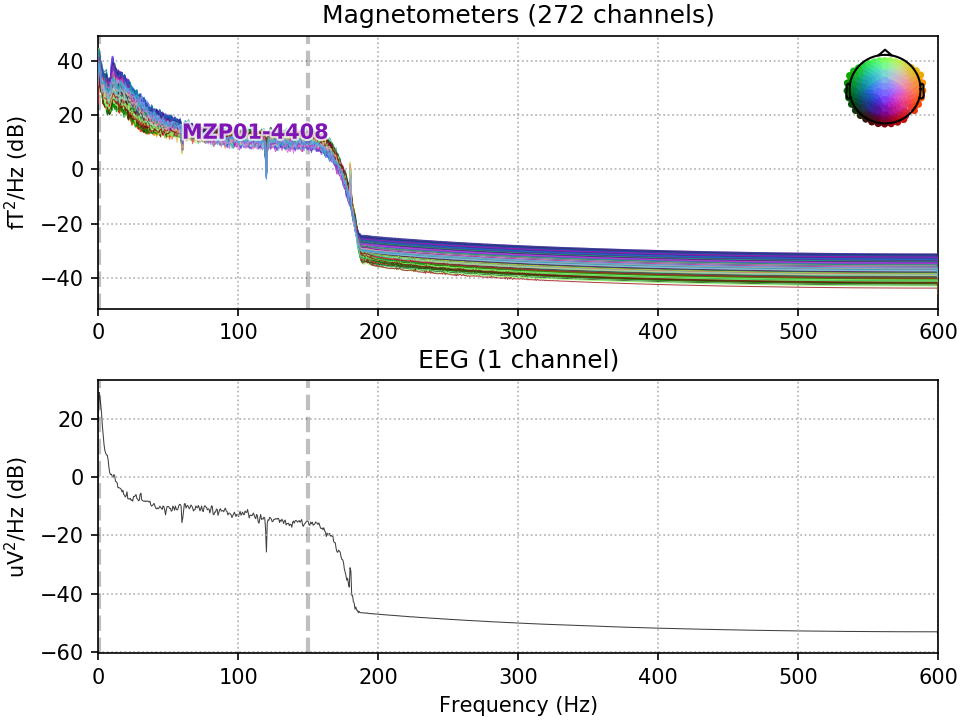

Effective window size : 1.707 (s)
Effective window size : 1.707 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


In [9]:
# Plot a new spectrum to see how the signal was modified
raw.plot_psd(tmax=60., average=False);

### ICA decomposition

The next classical step to MEG/EEG pre-processing is to run an Independent Component Analysis (ICA) in order to detect and remove occular and cardiac artifacts from our signal.

In [10]:
ica = mne.preprocessing.ICA(n_components=20, random_state=0).fit(raw, decim=3) # We compute an ICA object from the data.
# The n_components argument defines the number of components that we wish to obtain.
# It is also possible to state that 0<n_components<1, in which case it will define the proportion of variance that 
# we want to be explained by the N components. 

Fitting ICA to data using 273 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Removing 5 compensators from info because not all compensation channels were picked.
Removing 5 compensators from info because not all compensation channels were picked.
Selection by number: 20 components
Fitting ICA took 16.2s.


<IPython.core.display.Javascript object>


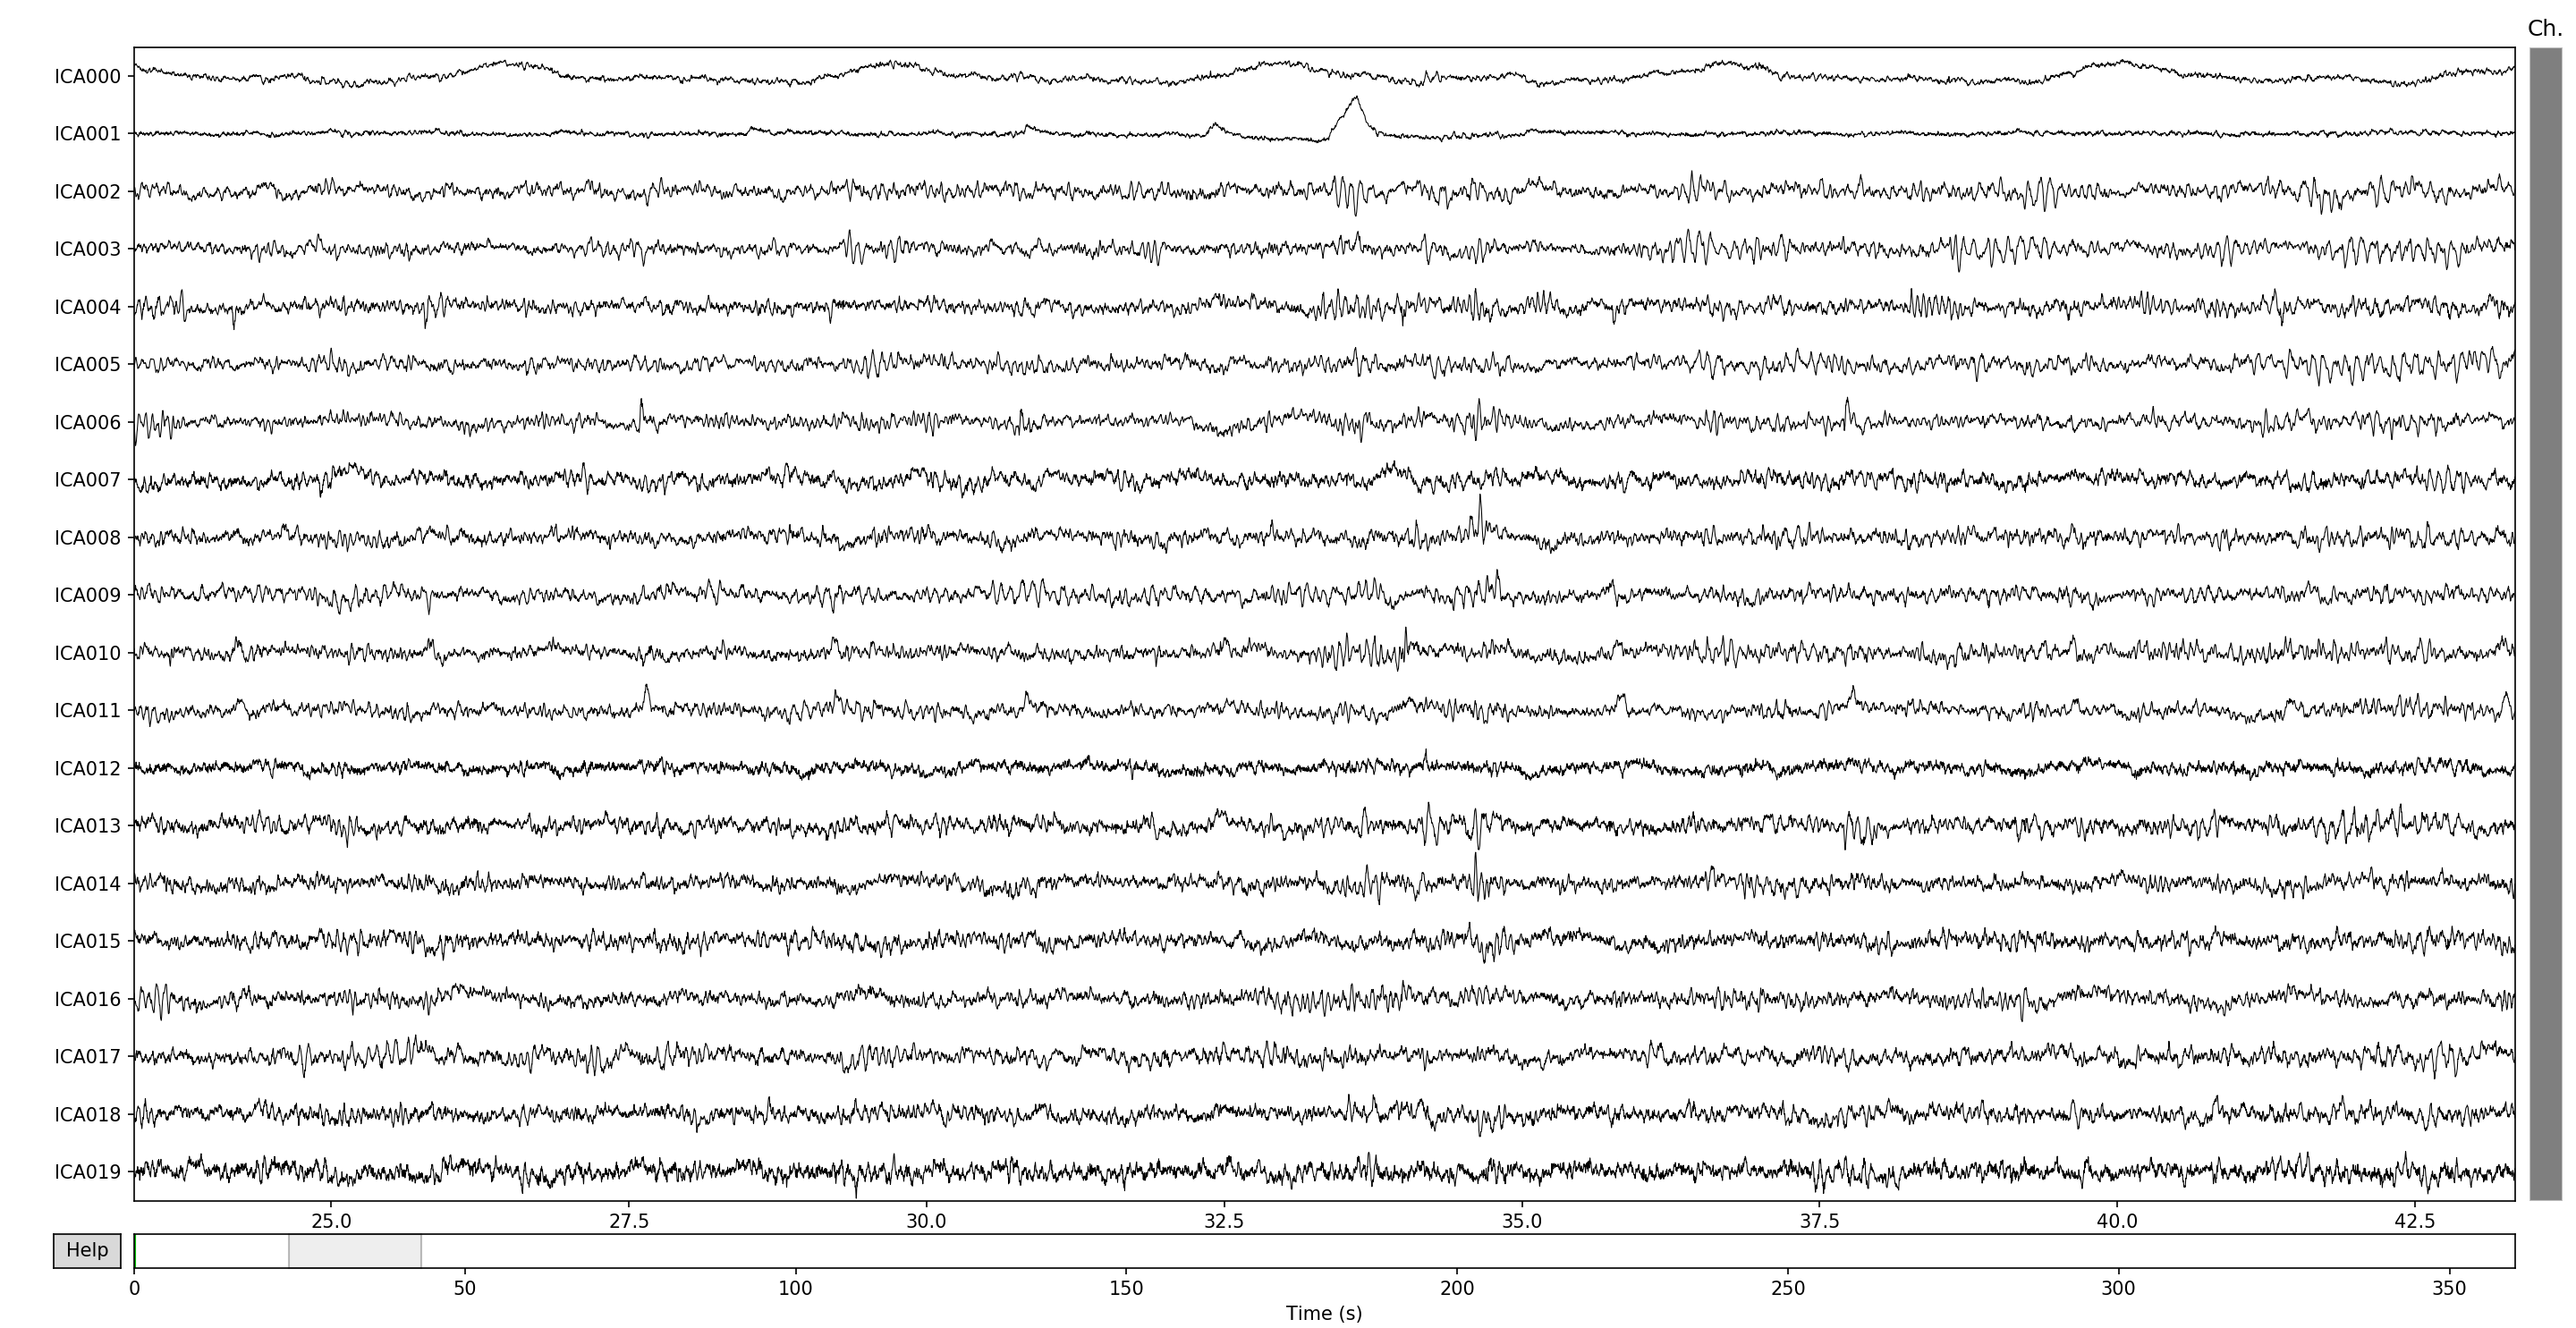

In [11]:
ica.plot_sources(raw); # We can plot our components and explore them visually to get 
                      # an idea of which artifact was captured by which component. What do we see ?

Looking at the above plot, we can guess that the last component (ICA019) captures cardiac activity. ICA001 looks like it has captured ocular blinks.
However, this is kind of arbitrary. Let's confirm our guesses with an automatic method. Hopefully, this dataset has an ECG and EOG channels that will help us find the artifactual components. If it is not the case, this method will still work although it may make more mistakes. 

Using channel EEG057 to identify heart beats.
Setting up band-pass filter from 8 - 16 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 8.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 7.75 Hz)
- Upper passband edge: 16.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 16.25 Hz)
- Filter length: 16384 samples (13.653 sec)


FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal allpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Filter length: 16384 samples (13.653 sec)

Number of ECG events detected : 348 (average pulse 58 / min.)
348 matching events found
No baseline correction applied
Not setting metadata
Loading data for 348 events and 1201 original time points ...
0 bad epochs dropped


<IPython.core.display.Javascript object>


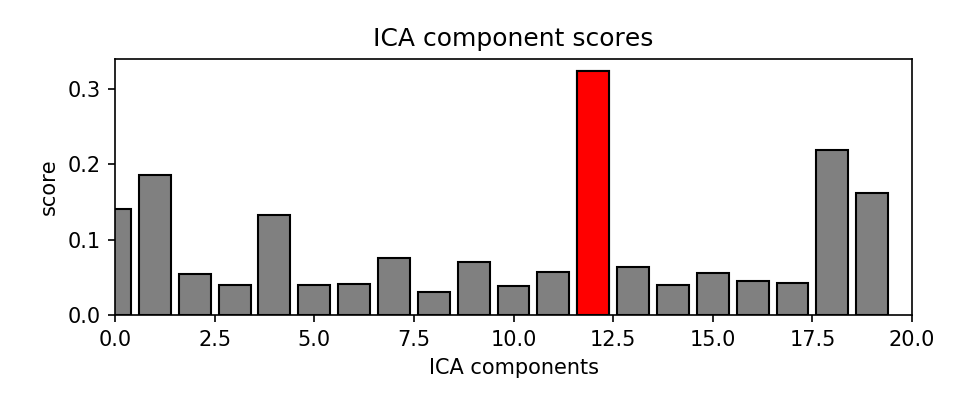

<IPython.core.display.Javascript object>


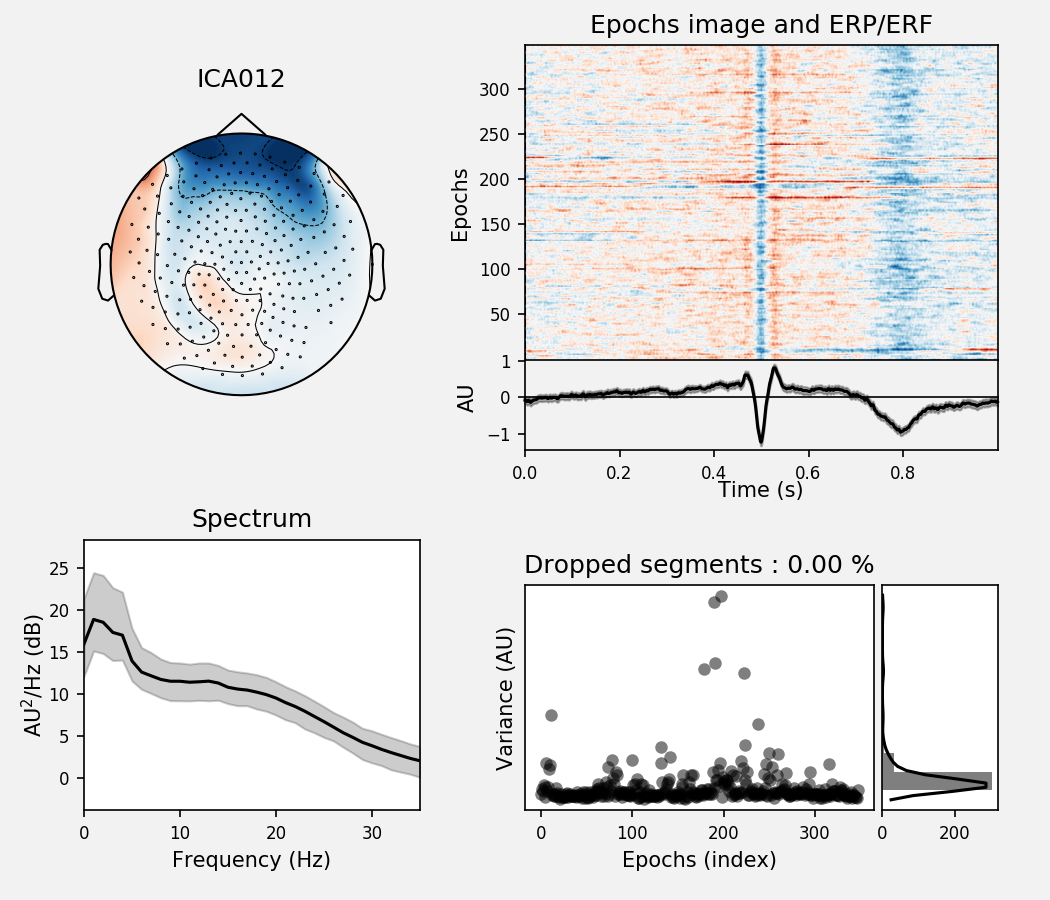

    Using multitaper spectrum estimation with 7 DPSS windows


In [12]:
# First, we will start by looking for the component(s) that captured cardiac activity.

ecg_epochs = create_ecg_epochs(raw, ch_name='EEG057') # This function will detect cardiac events (heartbeats) on the ECG signal
                                                      # and store their timestamps in "ecg_epochs".

ecg_inds, ecg_scores = ica.find_bads_ecg(ecg_epochs, ch_name='EEG057') # Now, this function correlates, at the timestamps
                                                      # specified by "ecg_epochs", the activity on EEG057 (our ECG channel) with
                                                      # each ICA component. The component with the greatest correlation is most
                                                      # likely the one we are looking for !

ica.plot_scores(ecg_scores, ecg_inds); # Let's plot the correlations scores for each ICA components. 
                                      # "ecg_inds" contains the indices of components identified as cardiac activity.

ica.plot_properties(ecg_epochs, picks=ecg_inds, psd_args={'fmax': 35.}, # Plot the topography and variance of the components in
                    image_args={'sigma': 1.});

Using channel EEG058 as EOG channel
EOG channel index for this subject is: [301]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 2 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 2.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 1.75 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 45.25 Hz)
- Filter length: 16384 samples (13.653 sec)

Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passba

<IPython.core.display.Javascript object>


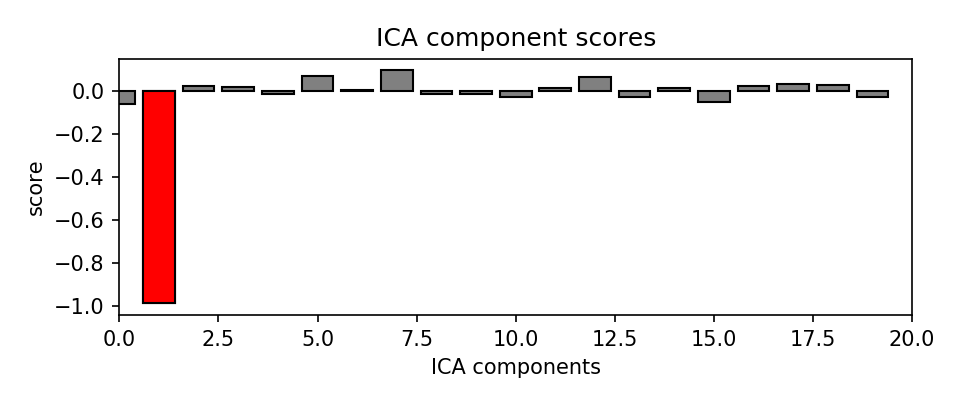

<IPython.core.display.Javascript object>


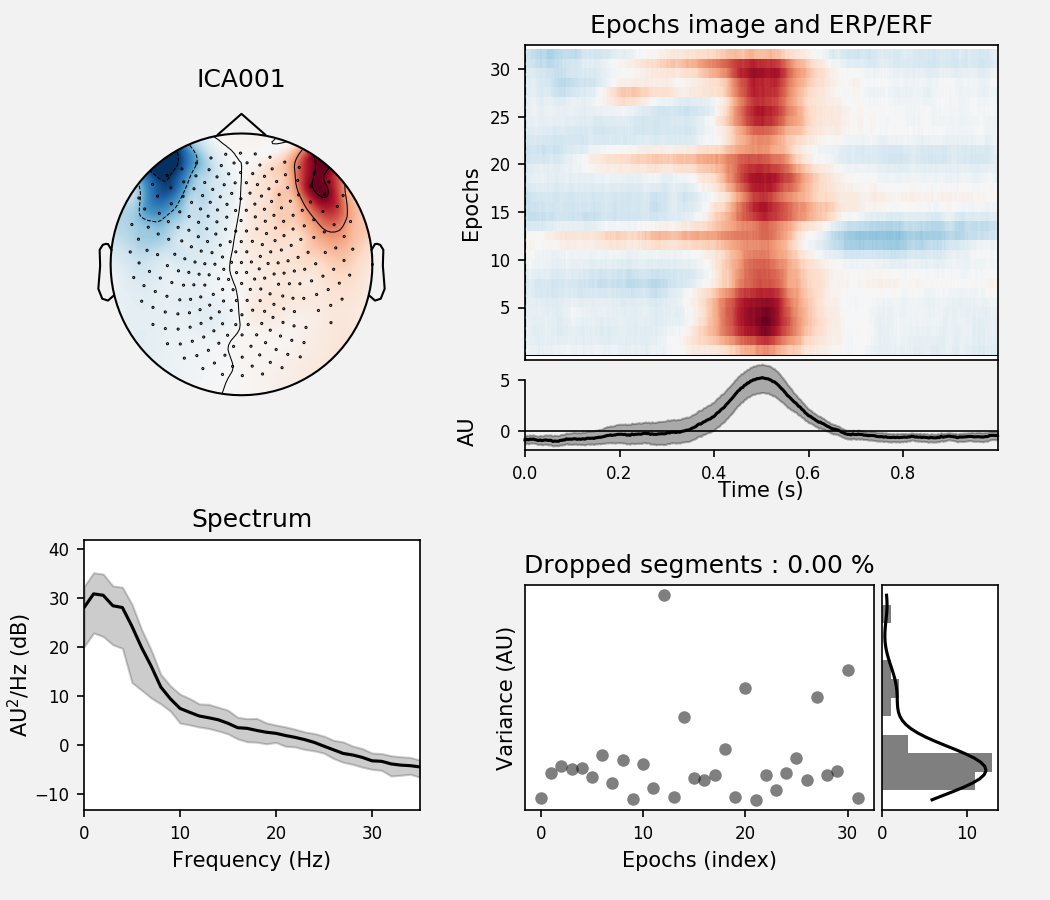

    Using multitaper spectrum estimation with 7 DPSS windows


In [13]:
# Now, let's do the same for ocular blinks. Note that two things have changed :
# - The functions used to detect artifacts are now called "eog" instead of "ecg"
# - The channel to which we correlate our components is now EEG058, the EOG channel
eog_epochs = create_eog_epochs(raw, ch_name='EEG058')
eog_inds, eog_scores = ica.find_bads_eog(eog_epochs, ch_name='EEG058')
ica.plot_scores(eog_scores, eog_inds);
ica.plot_properties(eog_epochs, picks=eog_inds, psd_args={'fmax': 35.},
                    image_args={'sigma': 1.});

Transforming to ICA space (20 components)
Zeroing out 1 ICA components
Transforming to ICA space (20 components)
Zeroing out 1 ICA components


<IPython.core.display.Javascript object>


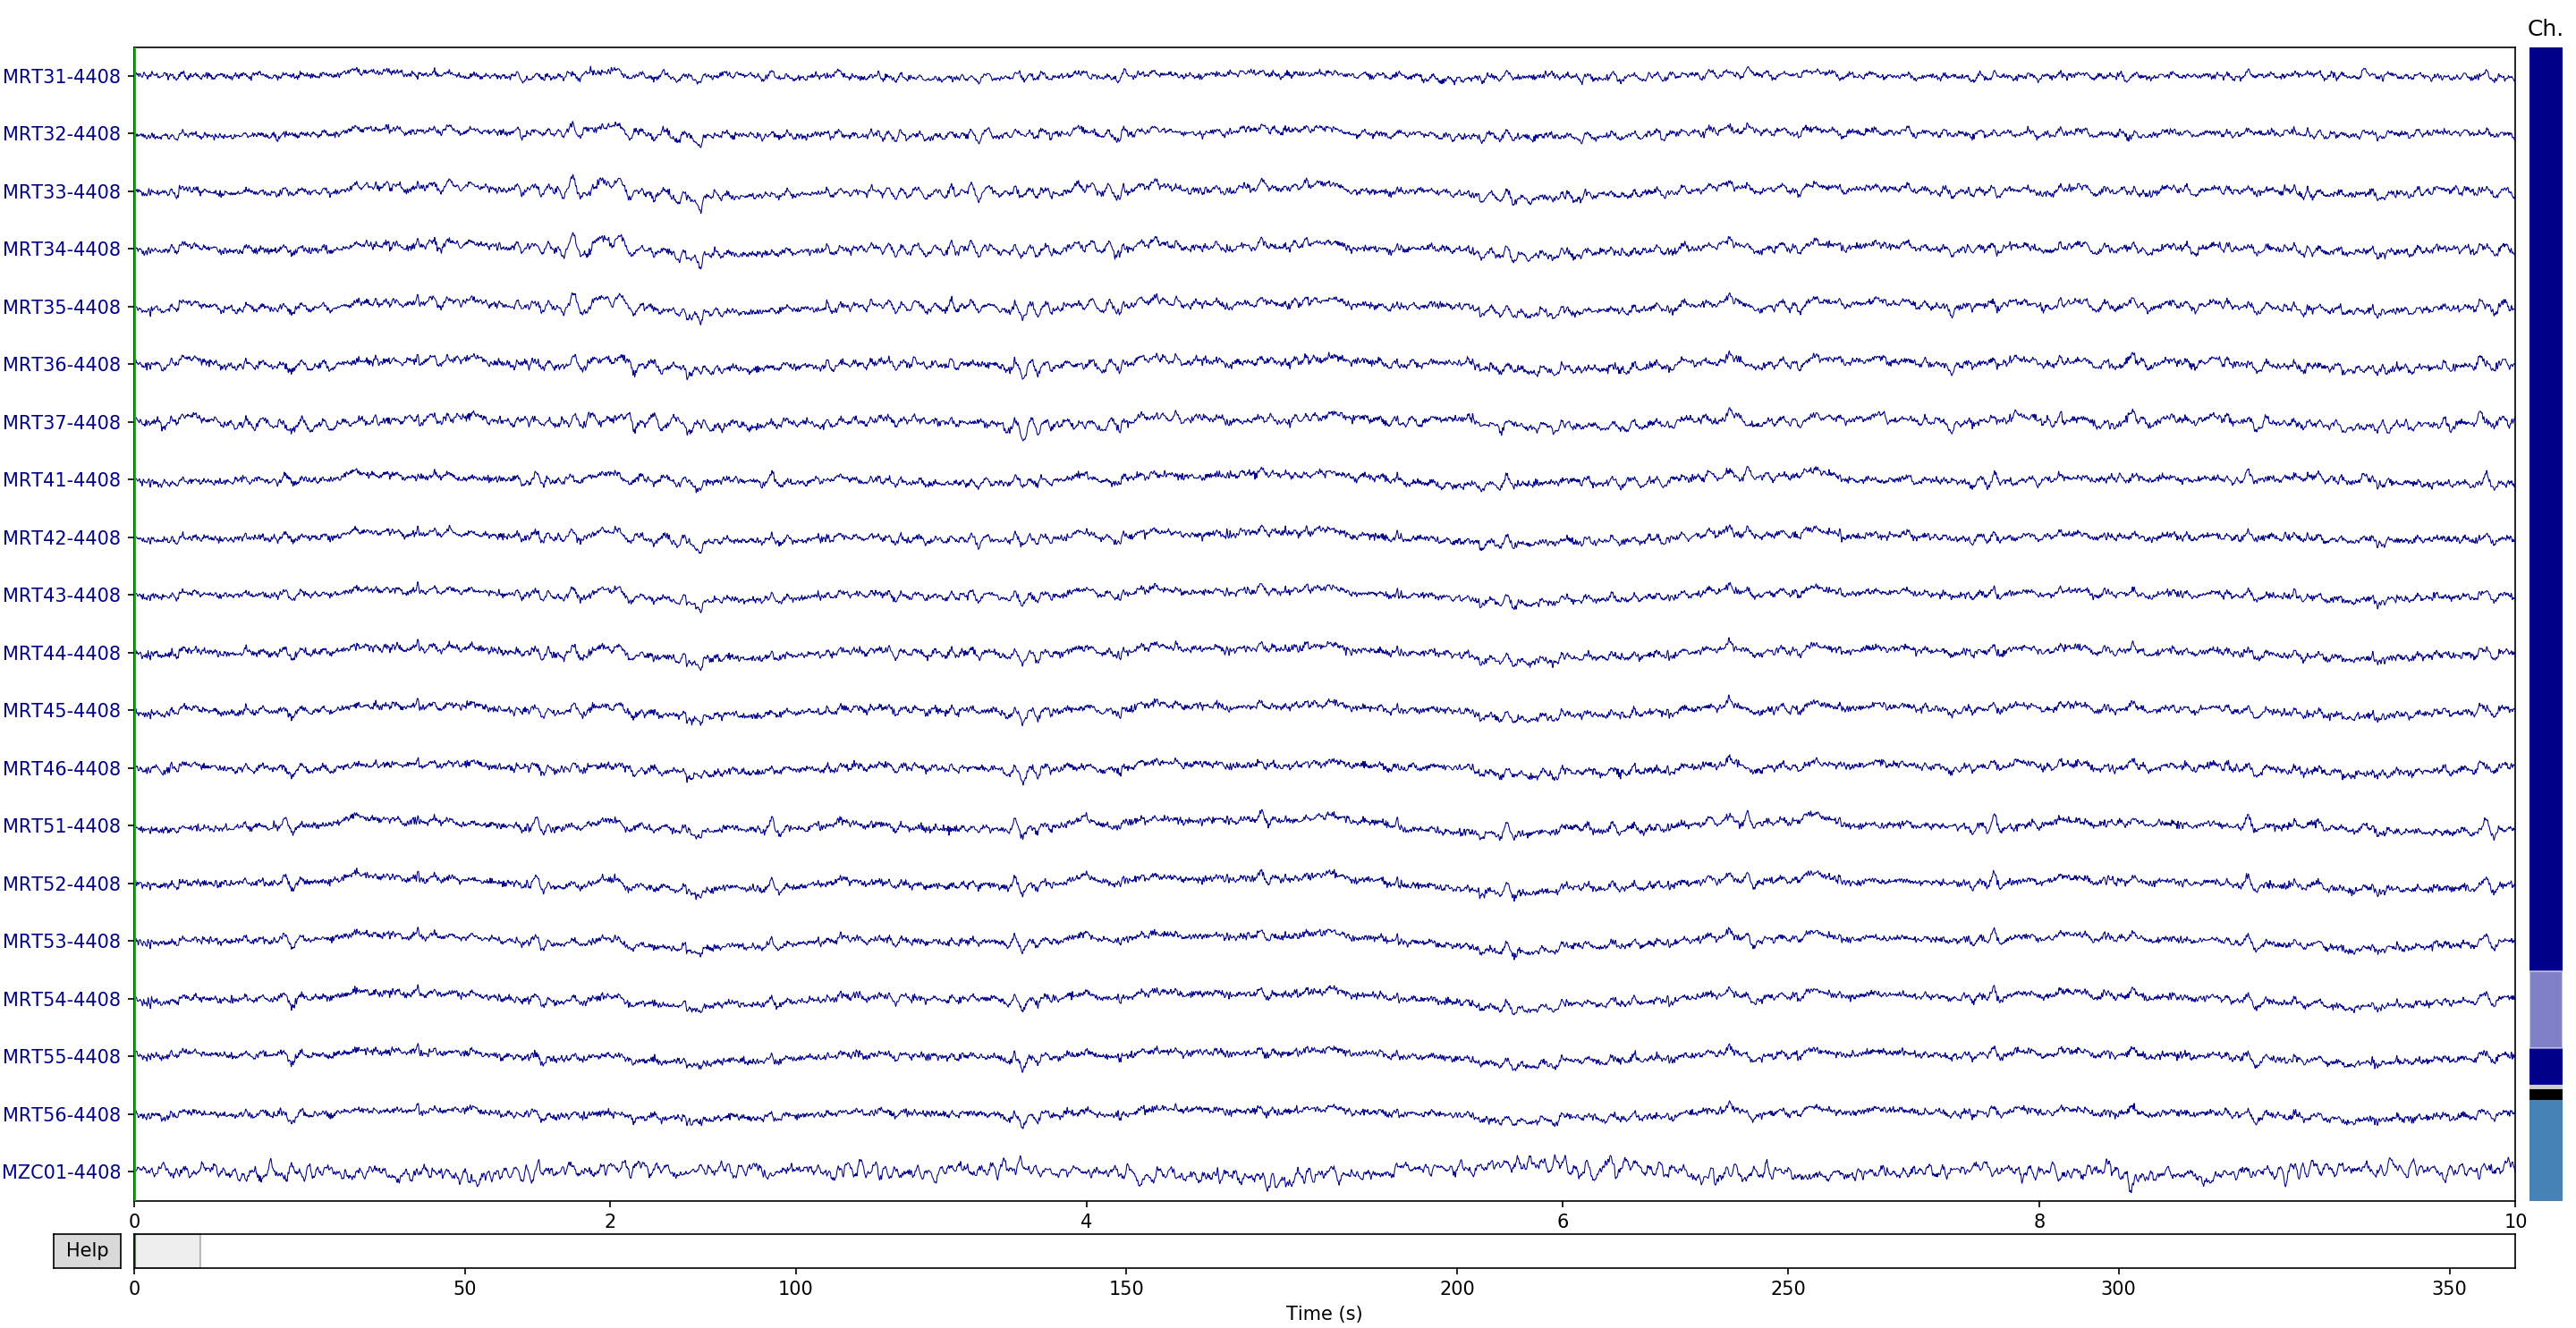

In [14]:
# Finally, we can recompose our signal while excluding the artifactual components : 

#ica.exclude = [1, 19] # We can also index the components individually, useful if we don't agree with the automatic detection

ica.exclude = ecg_inds # Exclude cardiac (ECG) or blinks (EOG) components 
ica.apply(raw) # Here we replace the old raw signal by the ICA recomposition

ica.exclude = eog_inds
ica.apply(raw) # Here we replace the old raw signal by the ICA recomposition


raw.plot(); # Plot the clean signal.

### Epoching
Last step, we need to split our data according to the stimulation condition (right or left hand stimulation). We can find the timestamps of these events using find_events() on the raw file, but this only works if the data file contains a STIM channel. If not, you'll have to find the timestamps elsewhere (or create them yourself).

200 events found
Event IDs: [1 2]


<IPython.core.display.Javascript object>


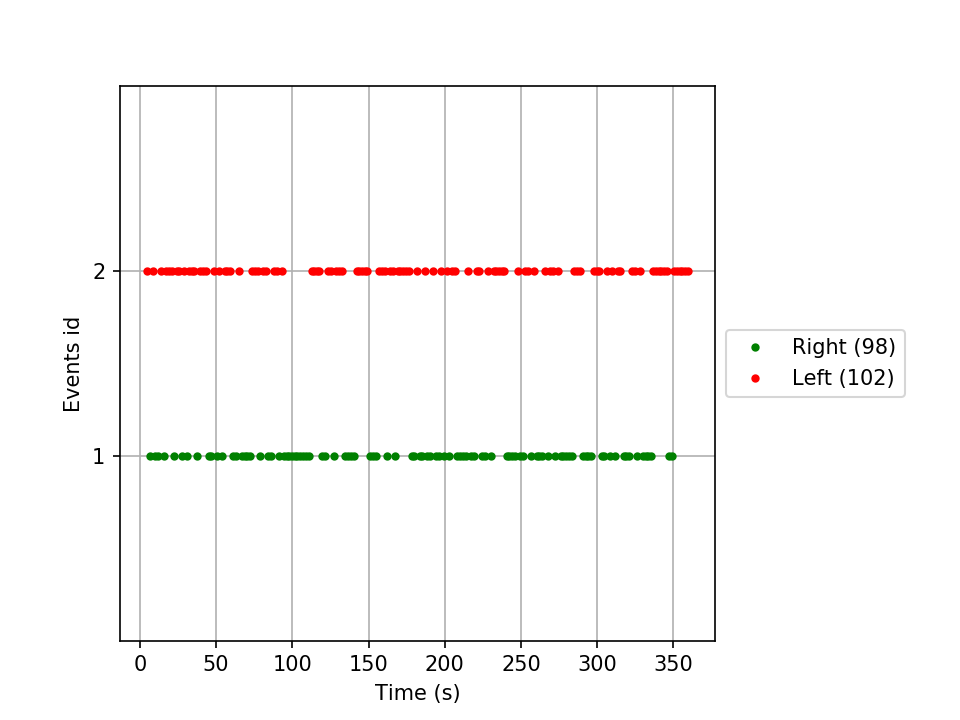

In [15]:
events = mne.find_events(raw)

event_id = {'Right': 1, 'Left': 2} # We define a name for each of our two conditions
color = {1: 'green', 2: 'red'} # And we also define a color that will be used to plot them

mne.viz.plot_events(events, raw.info['sfreq'], raw.first_samp, color=color,
                    event_id=event_id); # Now let's plot the events we found

### Rejection by threshold
It's not always possible to perfectly correct the signal using ICA de/recomposition, and sometimes it's not even possible to try (in the case of non-continuous datasets for example). Moreover, we sometimes want to be very agressive with the data preprocessing, and deciding to simply reject any segment exceeding a certain amplitude threshold can give good results. We just have to make sure that the threshold we go for is appropriate for our dataset, i.e. it doesn't reject too much nor too little of the signal.

In [ ]:
# The Epochs() function allows to automatically reject events in which one or more channels exceeds a
# threshold value. We can set different values for different types of channels (mag, grad, eeg etc...).
# This is useful because even a meticulous pre-processing may leave some noisy segments in the data, and
# this method only rejects the contaminated trials while keeping the others intact.

reject = dict(mag=3000e-15)

flat = dict(mag=1e-15)

In [ ]:
tmin, tmax = -0.2, 0.5 # Here we define the amount of time we want to keep before (tmin) and after (tmax) the event.
                       # Thus, we will split our signal into 0.7s chunks.
    
baseline = (None, 0.0) # When epoching, we often want to use some kind of baseline correction. Here, we define that our baseline
                       # starts at the beginning of the epoch and goes until the stimulus occurence (t=0)
                
picks = mne.pick_types(raw.info, meg='mag', eeg=False, eog=False) # We choose to analyse only the magnetometers ('mag')

epochs = mne.Epochs(raw, events=events, event_id=event_id, tmin=tmin,
                    tmax=tmax, baseline=baseline, reject=reject, 
                    flat=flat, reject_by_annotation=False, picks=picks, preload=False) # This function splits the signal into epochs that
                                                                             # can be accessed separately by calling epochs[condition]

epochs.drop_bad() # Here, we drop the epochs that were marked as bad using the "reject" parameter. 
                  # The dropped epochs will not be used for further analysis.
epochs.plot_drop_log();

### Saving datasets

In [ ]:
# Now that our pre-processing is done, it is time to save our clean dataset

filename = 'clean_dataset'
epochs.save(data_path + '/' + filename + '_epochs.fif.gz', overwrite=True) # May be necessary to switch between '\\' and '/' depending on your OS

In [ ]:
epochs['Left']
epochs['Right']

In [ ]:
raw.close()